### SP025 Integration analysis Lung TME 

In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri

In [3]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [5]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths("/home/spuccio/miniconda3/envs/scrnseq/lib/R/library")

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)
library(clustree)
library(SingleCellExperiment)
library(CHETAH)
library(SingleR)
library(cowplot)
library(Matrix)

### Load Dataset Lung

In [6]:
path_lung="/home/spuccio/isilon/spuccio/SP025_NaClTcell/PangenomeBlueprint/LC_counts/"
adata_lung = sc.read("".join([path_lung,"matrix.mtx"]), cache=True)
adata_lung = adata_lung.transpose()
adata_lung.X = adata_lung.X.toarray()
barcodes = pd.read_csv("".join([path_lung,"barcodes.tsv"]), header=None, sep='\t')
genes = pd.read_csv("".join([path_lung,"genes.tsv"]), header=None, sep='\t')
#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata_lung.obs = barcodes
genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata_lung.var = genes
Metadata_lung = pd.read_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/PangenomeBlueprint/LC_metadata.csv",header=0,low_memory=False)
adata_lung.obs['CellId'] = Metadata_lung["Cell"].astype('category')
adata_lung.obs['CellFromTumor'] = Metadata_lung["CellFromTumor"].to_list()
adata_lung.obs['PatientNumber'] = Metadata_lung["PatientNumber"].to_list()
adata_lung.obs['TumorType'] = Metadata_lung["TumorType"].to_list()
adata_lung.obs['TumorSite'] = Metadata_lung["TumorSite"].to_list()
adata_lung.obs['CellType'] = Metadata_lung["CellType"].to_list()
adenocarcinomacell = (adata_lung.obs['PatientNumber'] == 3) | (adata_lung.obs['PatientNumber'] == 4) | (adata_lung.obs['PatientNumber'] == 6)
adata_lung = adata_lung[adenocarcinomacell, :]

... reading from cache file cache/home-spuccio-isilon-spuccio-SP025_NaClTcell-PangenomeBlueprint-LC_counts-matrix.h5ad


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
adata_lung_Tcell = adata_lung[adata_lung.obs['CellType']  == "T_cell",:]
adata_lung_Cancer = adata_lung[adata_lung.obs['CellType']  == "Cancer",:]

### Filter low expressed genes

In [8]:
sc.pp.filter_genes(adata_lung_Tcell, min_cells=10)
sc.pp.filter_cells(adata_lung_Tcell, min_genes=200)

filtered out 18098 genes that are detected in less than 10 cells


Trying to set attribute `.var` of view, copying.


filtered out 1 cells that have less than 200 genes expressed


In [9]:
adata_lung_Tcell.raw = adata_lung_Tcell

### QC metrics

In [10]:
sc.pp.calculate_qc_metrics(adata_lung_Tcell, inplace=True)

In [11]:
adata_lung_Tcell.var['mt'] = adata_lung_Tcell.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_lung_Tcell, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [12]:
adata_lung_Tcell.var['rb'] = adata_lung_Tcell.var_names.str.startswith('RP')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_lung_Tcell, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

In [13]:
#sc.pl.violin(adata_lung_Tcell, ['pct_counts_mt'],
#             jitter=0.4, multi_panel=False)

normalizing counts per cell
    finished (0:00:00)


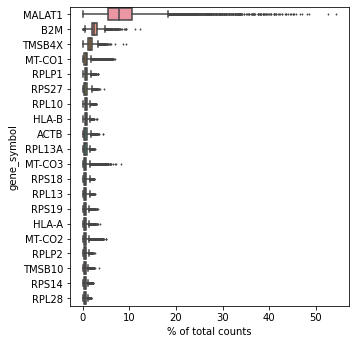

In [14]:
sc.pl.highest_expr_genes(adata_lung_Tcell, n_top=20)

In [15]:
print("Cell x Genes before filtering")
print(adata_lung_Tcell.n_obs, adata_lung_Tcell.n_vars)

Cell x Genes before filtering
18942 15596


In [16]:
#sc.pl.violin(adata_lung_Tcell, ['pct_counts_rb'],jitter=0.4)

In [17]:
adata_lung_Tcell = adata_lung_Tcell[adata_lung_Tcell.obs.pct_counts_rb < 40, :]
print("Cell x Genes after filtering cell with high ribosomial")
print(adata_lung_Tcell.n_obs, adata_lung_Tcell.n_vars)

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Cell x Genes after filtering cell with high ribosomial
18332 15596


In [18]:
#sc.pl.violin(adata_lung_Tcell, ['pct_counts_mt'],jitter=0.4)

In [19]:
adata_lung_Tcell = adata_lung_Tcell[adata_lung_Tcell.obs.pct_counts_mt < 10, :]
print("Cell x Genes after filtering cell with high mithocondrial")
print(adata_lung_Tcell.n_obs, adata_lung_Tcell.n_vars)

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


Cell x Genes after filtering cell with high mithocondrial
17085 15596


In [20]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["external_gene_name", "start_position", "end_position", "chromosome_name","gene_biotype"],).set_index("external_gene_name")

In [21]:
annot['gene_biotype'].unique()

array(['Mt_tRNA', 'Mt_rRNA', 'protein_coding', 'processed_pseudogene',
       'lncRNA', 'snRNA', 'unprocessed_pseudogene', 'misc_RNA',
       'transcribed_unprocessed_pseudogene',
       'transcribed_processed_pseudogene', 'TEC', 'rRNA',
       'IG_V_pseudogene', 'rRNA_pseudogene', 'miRNA',
       'transcribed_unitary_pseudogene', 'unitary_pseudogene', 'snoRNA',
       'scaRNA', 'polymorphic_pseudogene', 'pseudogene', 'ribozyme',
       'sRNA', 'TR_V_gene', 'TR_V_pseudogene', 'TR_D_gene', 'TR_J_gene',
       'TR_C_gene', 'TR_J_pseudogene', 'IG_C_gene', 'IG_C_pseudogene',
       'IG_J_gene', 'IG_J_pseudogene', 'IG_D_gene', 'IG_V_gene',
       'IG_pseudogene', 'translated_processed_pseudogene', 'scRNA',
       'vault_RNA', 'translated_unprocessed_pseudogene'], dtype=object)

In [22]:
#len(pd.merge(pd.DataFrame(adata_lung_Tcell.var_names),annot,left_on="gene_symbol",right_on="external_gene_name",how="left"))

In [23]:
annot = pd.merge(pd.DataFrame(adata_lung_Tcell.var_names),annot,left_on="gene_symbol",right_on="external_gene_name",how="left")

In [24]:
annot= annot.drop_duplicates(['gene_symbol'])

In [25]:
annot = annot.fillna("Not_available")

In [26]:
adata_lung_Tcell.var['gene_biotype'] = annot.set_index("gene_symbol")['gene_biotype']
protein_coding = annot['gene_symbol'].loc[annot['gene_biotype']=="protein_coding"].reset_index()
del protein_coding['index']
protein_gene_indicator = np.in1d(adata_lung_Tcell.var_names, protein_coding)
adata_lung_Tcell = adata_lung_Tcell[:, protein_gene_indicator]

Trying to set attribute `.var` of view, copying.


In [27]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [28]:
mito_gene_indicator = np.in1d(adata_lung_Tcell.var_names, mito_gene_names)

In [29]:
adata_lung_Tcell = adata_lung_Tcell[:, ~mito_gene_indicator]

In [30]:
adata_lung_Tcell

View of AnnData object with n_obs × n_vars = 17085 × 12773
    obs: 'CellId', 'CellFromTumor', 'PatientNumber', 'TumorType', 'TumorSite', 'CellType', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rb', 'pct_counts_rb'
    var: 'gene_id', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'rb', 'gene_biotype'

In [31]:
print(adata_lung_Tcell.n_obs, adata_lung_Tcell.n_vars)
malat1 = adata_lung_Tcell.var_names.str.startswith('MALAT1')
#protein_genes= adata_lung_Tcell.var.gene_biotype.str.startswith('protein_coding')
ribo_genes = adata_lung_Tcell.var_names.str.startswith(("RPS","RPL"))
remove = np.add(ribo_genes, malat1)
keep = np.invert(remove)

adata_lung_Tcell = adata_lung_Tcell[:,keep]

print(adata_lung_Tcell.n_obs, adata_lung_Tcell.n_vars)

17085 12773
17085 12677


In [32]:
print(adata_lung_Tcell.n_obs, adata_lung_Tcell.n_vars)

17085 12677


In [33]:
adata_lung_Tcell.raw = adata_lung_Tcell

In [34]:
sc.pp.normalize_total(adata_lung_Tcell, target_sum=1e4,exclude_highly_expressed=True)
sc.pp.log1p(adata_lung_Tcell)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['TNFRSF4', 'TMSB10', 'GNLY', 'JCHAIN', 'CXCL13', 'GZMA', 'CD74', 'SCGB3A1', 'ACTB', 'TMSB4X', 'SFTPC', 'HBB', 'FTH1', 'SCGB1A1', 'GZMB', 'HSP90AA1', 'B2M', 'HBA2', 'HBA1', 'MT2A', 'PFN1', 'CCL3', 'CCL4', 'CCL4L2', 'FTL']
    finished (0:00:00)


In [35]:
sc.pp.highly_variable_genes(adata_lung_Tcell, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [36]:
adata_lung_Tcell.raw = adata_lung_Tcell

In [37]:
#pd.DataFrame(adata_lung_Tcell.var.highly_variable).loc[pd.DataFrame(adata_lung_Tcell.var.highly_variable)['highly_variable'] == True].head(50)

normalizing counts per cell
    finished (0:00:00)


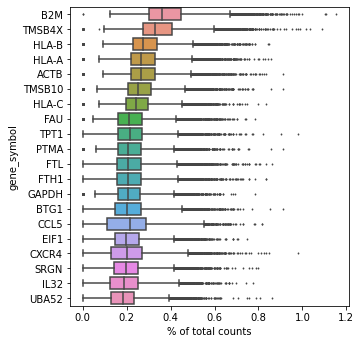

In [38]:
sc.pl.highest_expr_genes(adata_lung_Tcell, n_top=20)

### Principal component analysis

In [39]:
#adata_lung_Tcell = adata_lung_Tcell[:, adata_lung_Tcell.var.highly_variable]

In [40]:
#sc.pp.scale(adata_lung_Tcell, max_value=10)

In [41]:
sc.tl.pca(adata_lung_Tcell, svd_solver='arpack',use_highly_variable=True)

computing PCA
    on highly variable genes
    with n_comps=50


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


    finished (0:00:01)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'TumorType' as categorical
... storing 'TumorSite' as categorical
... storing 'CellType' as categorical
... storing 'gene_biotype' as categorical


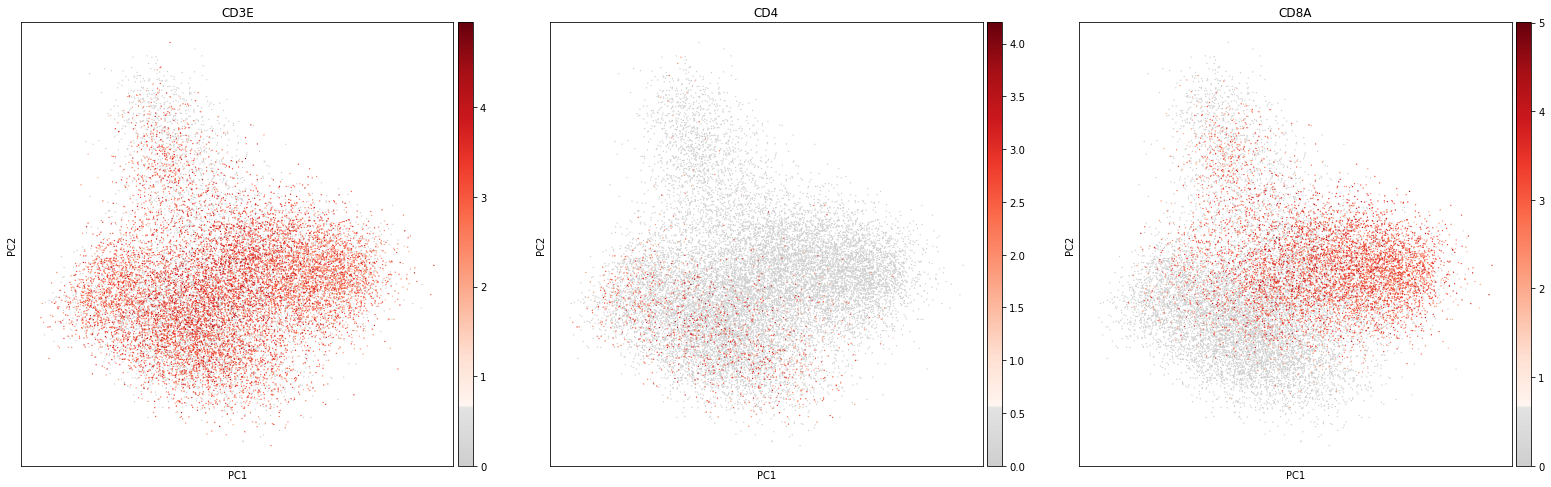

In [42]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.pca(adata_lung_Tcell, color=['CD3E','CD4','CD8A'],color_map=mymap)

### Computing the neighborhood graph

In [43]:
sc.pp.neighbors(adata_lung_Tcell, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


### Embedding the neighborhood graph

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


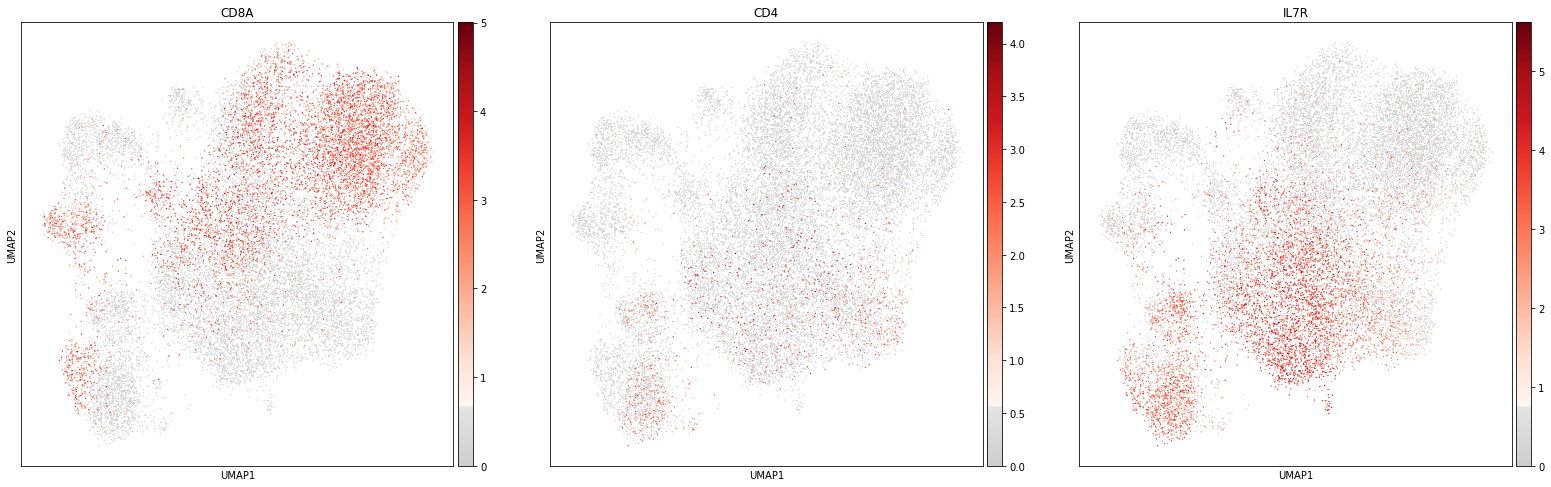

In [44]:
sc.tl.umap(adata_lung_Tcell)
sc.pl.umap(adata_lung_Tcell, color=['CD8A', 'CD4', 'IL7R'],color_map=mymap,use_raw=True); plt.show()

### Clustering the neighborhood graph

In [45]:
sc.tl.leiden(adata_lung_Tcell, resolution=0.7, key_added='leiden_r7_clusters',random_state=49)
sc.tl.leiden(adata_lung_Tcell, resolution=0.5, key_added='leiden_r5_clusters',random_state=49)
sc.tl.leiden(adata_lung_Tcell, resolution=0.4, key_added='leiden_r4_clusters',random_state=49)
sc.tl.leiden(adata_lung_Tcell, resolution=0.6, key_added='leiden_r6_clusters',random_state=49)
sc.tl.leiden(adata_lung_Tcell, resolution=0.8, key_added='leiden_r8_clusters',random_state=49)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_r7_clusters', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_r5_clusters', the cluster labels (adata.obs, categorical) (0:00:02)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden_r4_clusters', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden_r6_clusters', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_r8_clusters', the cluster labels (adata.obs, categorical) (0:00:01)


### clustree: Visualise Clusterings at Different Resolutions.

In [46]:
data_clus = adata_lung_Tcell.obs[['leiden_r7_clusters','leiden_r5_clusters','leiden_r4_clusters','leiden_r6_clusters','leiden_r8_clusters']]

In [47]:
data_clus.to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index_col=0,header=0)

In [48]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command
import rpy2
old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

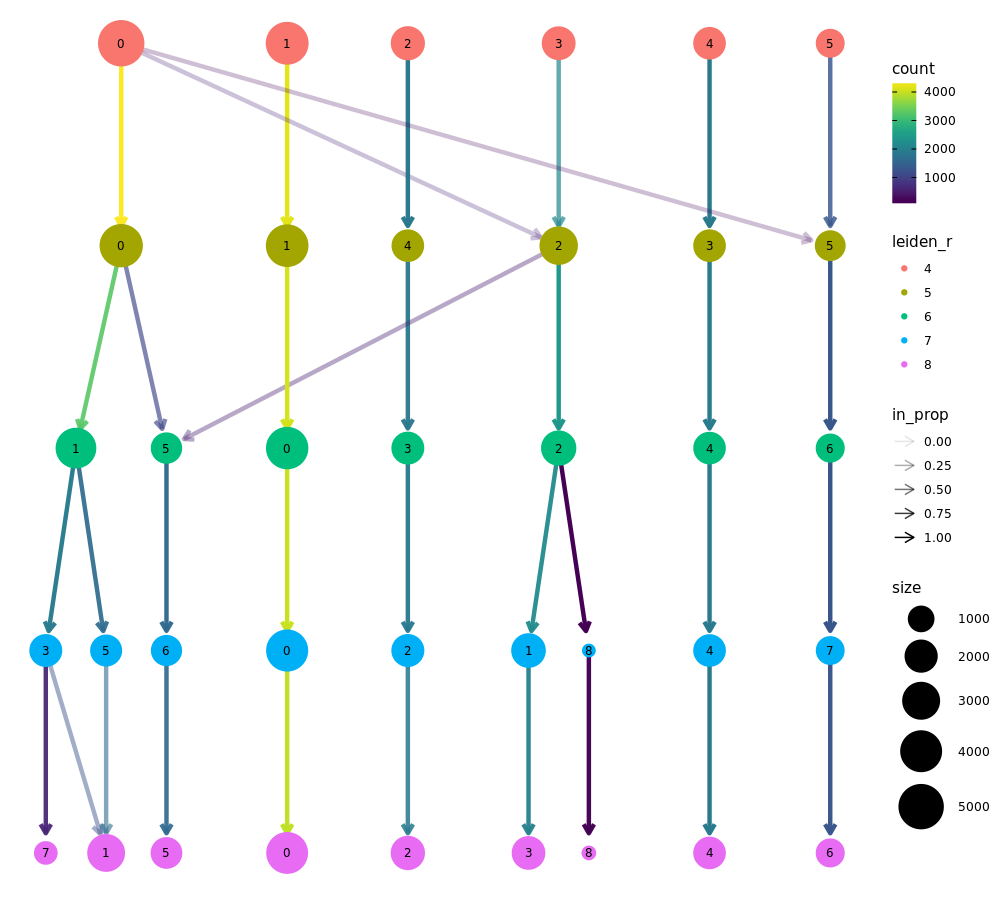

In [49]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="leiden_r",suffix = "_clusters")

## UMAP of Cluster 

In [50]:
sc.tl.paga(adata_lung_Tcell,groups='leiden_r6_clusters')
sc.pl.paga(adata_lung_Tcell, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata_lung_Tcell, init_pos='paga')

running PAGA


/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


In [51]:
new_cluster_names = ['0','1','2','3','4','5','6']
adata_lung_Tcell.rename_categories('leiden_r6_clusters', new_cluster_names)

In [52]:
sc.tl.louvain(adata_lung_Tcell, restrict_to=('leiden_r6_clusters', ['6']), resolution=0.2, key_added='louvain_r0.2_entero_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('leiden_r6_clusters', ['6']), resolution=0.4, key_added='louvain_r0.4_entero_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('leiden_r6_clusters', ['6']), resolution=0.6, key_added='louvain_r0.6_entero_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('leiden_r6_clusters', ['6']), resolution=0.7, key_added='louvain_r0.7_entero_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('leiden_r6_clusters', ['6']), resolution=0.8, key_added='louvain_r0.8_entero_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('leiden_r6_clusters', ['6']), resolution=0.9, key_added='louvain_r0.9_entero_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain_r0.2_entero_sub', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.4_entero_sub', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain_r0.6_entero_sub', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r0.7_entero_sub', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r0.8_entero_sub', the cluster labels (adata.obs, categorical) (0:

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


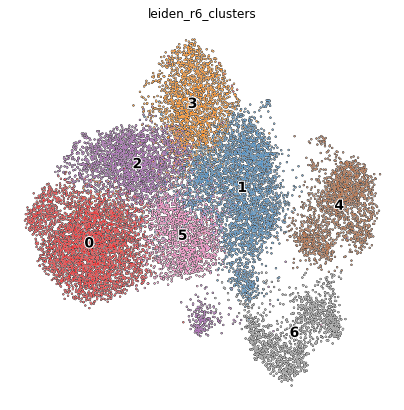

In [53]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_lung_Tcell, color='leiden_r6_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='leiden_r6_clusters', palette='Set1')

In [54]:
adata_lung_Tcell.obs['louvain_r0.2_entero_sub'].value_counts()

0      4130
1      3679
2      2422
3      1947
4      1896
5      1688
6,0     767
6,1     556
Name: louvain_r0.2_entero_sub, dtype: int64

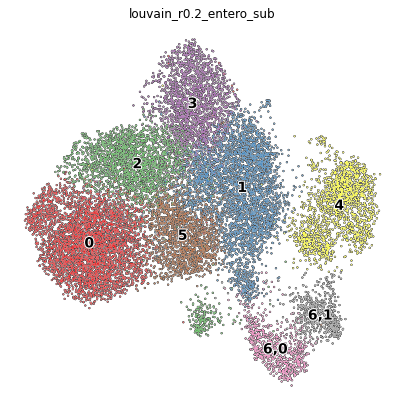

In [55]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_lung_Tcell, color='louvain_r0.2_entero_sub', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='louvain_r0.2_entero_sub', palette='Set1')

In [56]:
list_old = adata_lung_Tcell.obs['louvain_r0.2_entero_sub'].tolist()
list_new= list_old
for n, i in enumerate(list_old):
    if i == '0':
        list_new[n] = '0'    
    if i == '1':
        list_new[n] = '1'
    if i == '2':
        list_new[n] = '2'
    if i == '3':
        list_new[n] = '3'
    if i == '4':
        list_new[n] = '4'
    if i == '5':
        list_new[n] = '5'
    if i == '6,0':
        list_new[n] = '6'
    if i == '6,1':
        list_new[n] = '7'

In [57]:
adata_lung_Tcell.obs['louvain_r0.2_entero_sub']=list_new

In [58]:
adata_lung_Tcell.obs['louvain_r0.2_entero_sub'].value_counts()

0    4130
1    3679
2    2422
3    1947
4    1896
5    1688
6     767
7     556
Name: louvain_r0.2_entero_sub, dtype: int64

In [59]:
adata_lung_Tcell.obs['louvain_r0.2_entero_sub'] = adata_lung_Tcell.obs['louvain_r0.2_entero_sub'].astype('category')

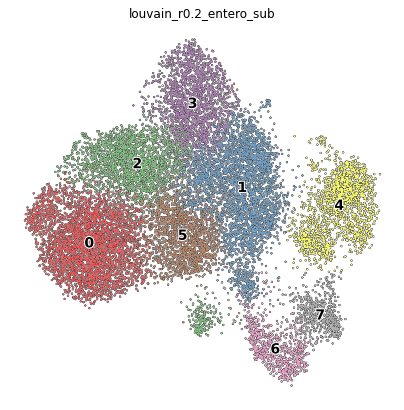

In [60]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_lung_Tcell, color='louvain_r0.2_entero_sub', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='louvain_r0.2_entero_sub', palette='Set1')

In [61]:
#sc.tl.louvain(adata_lung_Tcell, restrict_to=('louvain_r0.2_entero_sub', ['5']), resolution=0.2, key_added='louvain_r0.2_entero_sub_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('louvain_r0.2_entero_sub', ['4']), resolution=0.4, key_added='louvain_r0.4_entero_sub_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('louvain_r0.2_entero_sub', ['4']), resolution=0.6, key_added='louvain_r0.6_entero_sub_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('louvain_r0.2_entero_sub', ['4']), resolution=0.7, key_added='louvain_r0.7_entero_sub_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('louvain_r0.2_entero_sub', ['4']), resolution=0.8, key_added='louvain_r0.8_entero_sub_sub')
sc.tl.louvain(adata_lung_Tcell, restrict_to=('louvain_r0.2_entero_sub', ['4']), resolution=0.9, key_added='louvain_r0.9_entero_sub_sub')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 11 clusters and added
    'louvain_r0.4_entero_sub_sub', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r0.6_entero_sub_sub', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r0.7_entero_sub_sub', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r0.8_entero_sub_sub', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain_r0.9_entero_sub_sub', the cluster labels (adat

In [62]:
adata_lung_Tcell.obs['louvain_r0.4_entero_sub_sub'].value_counts()

0      4130
1      3679
2      2422
3      1947
5      1688
4,0    1009
6       767
7       556
4,1     487
4,2     325
4,3      75
Name: louvain_r0.4_entero_sub_sub, dtype: int64

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


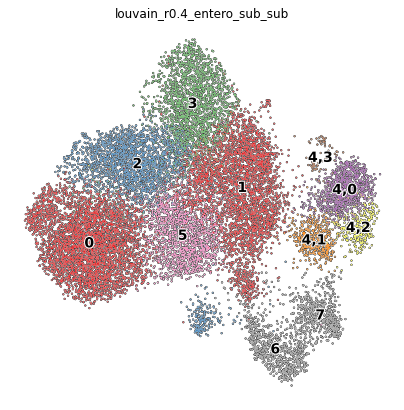

In [63]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_lung_Tcell, color='louvain_r0.4_entero_sub_sub', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='louvain_r0.4_entero_sub_sub', palette='Set1')

In [64]:
list_old = adata_lung_Tcell.obs['louvain_r0.4_entero_sub_sub'].tolist()
list_new= list_old
for n, i in enumerate(list_old):
    if i == '0':
        list_new[n] = '0'    
    if i == '1':
        list_new[n] = '1'
    if i == '2':
        list_new[n] = '2'
    if i == '3':
        list_new[n] = '3'
    if i == '4,0':
        list_new[n] = '4'
    if i == '5':
        list_new[n] = '5'
    if i == '6':
        list_new[n] = '6'
    if i == '7':
        list_new[n] = '7'
    if i == '4,1':
        list_new[n] = '4'
    if i == '4,2':
        list_new[n] = '8'
    if i == '4,3':
        list_new[n] = '4'

In [65]:
adata_lung_Tcell.obs['louvain_r0.4_entero_sub_sub']=list_new

... storing 'louvain_r0.4_entero_sub_sub' as categorical


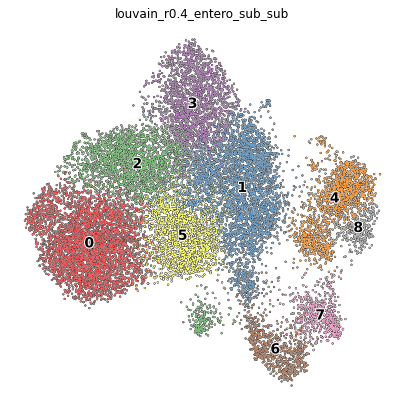

In [66]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_lung_Tcell, color='louvain_r0.4_entero_sub_sub', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='louvain_r0.4_entero_sub_sub', palette='Set1')

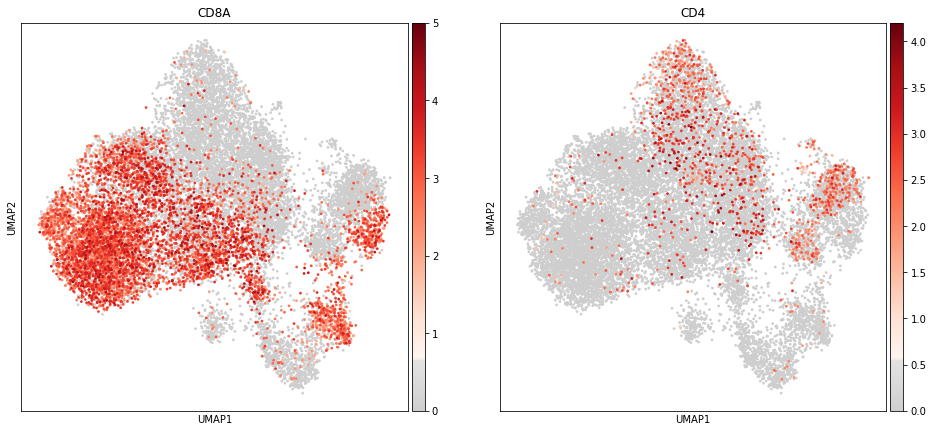

In [67]:
sc.pl.umap(adata_lung_Tcell, color=['CD8A','CD4'],color_map=mymap,legend_loc='on data',s=30 )

### Number of cells X cluster 

In [68]:
adata_lung_Tcell.obs['leiden_r6_clusters'] = adata_lung_Tcell.obs['louvain_r0.4_entero_sub_sub'] 

In [69]:
adata_lung_Tcell.obs['leiden_r6_clusters'].value_counts()

0    4130
1    3679
2    2422
3    1947
5    1688
4    1571
6     767
7     556
8     325
Name: leiden_r6_clusters, dtype: int64

In [70]:
adata_lung_Tcell.obs['leiden_r6_clusters'].value_counts(normalize=True)*100

0    24.173251
1    21.533509
2    14.176178
3    11.395961
5     9.880012
4     9.195200
6     4.489318
7     3.254317
8     1.902253
Name: leiden_r6_clusters, dtype: float64

In [71]:
adata_lung_Tcell.obs['leiden_r6_clusters'] = adata_lung_Tcell.obs['louvain_r0.4_entero_sub_sub']  

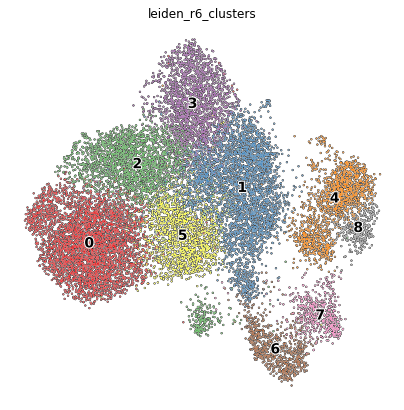

In [72]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_lung_Tcell, color='leiden_r6_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='leiden_r6_clusters', palette='Set1')

In [73]:
adata_lung_Tcell = adata_lung_Tcell[adata_lung_Tcell.obs['leiden_r6_clusters'].isin(['0','1','2','3','4','5','6']),:]

/home/spuccio/miniconda3/envs/cytophenograph/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Finding marker genes

In [74]:
sc.tl.rank_genes_groups(adata_lung_Tcell, 'leiden_r6_clusters', method='wilcoxon')
pd.DataFrame(adata_lung_Tcell.uns['rank_genes_groups']['names']).head(50)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


0         1         2         3         4         5       6
0     CXCL13      IL7R    TMSB4X       LTB      FTH1      GZMK    NKG7
1       LAG3     CXCR4    HSPA1A      IL32    EEF1A1      CST7  TYROBP
2       NKG7      BTG1       CD7   TNFRSF4     ANXA1     CXCR4    PRF1
3       GZMB     TXNIP      CCL5      SAT1     SFTPC    GIMAP7  FGFBP2
4      ISG15       FOS    HSPA1B  TNFRSF18       VIM     HLA-A   KLRF1
5       CD8A      JUNB       ID2     TIGIT     CRIP1      CD8B   SPON2
6      GAPDH   TSC22D3      GZMA      BATF     ZFP36    CLDND1    GNLY
7       IFI6      CD69      CD63    ARID5B      TPT1    GIMAP4  FCGR3A
8       LY6E   ZFP36L2      GZMB      SELL       FTL      CCL4   KLRB1
9       GZMA      TPT1  SH3BGRL3     RTKN2   S100A10      GZMA   KLRD1
10    HAVCR2      KLF6      CD3D     CTLA4     SARAF     HLA-B  FCER1G
11       MX1     ANXA1     KLRD1     IL2RA     APOC1      LYAR    CST7
12      CCL3     SARAF     KLRB1      CD27      SRGN     HLA-E   PLAC8
13      GZMH    PABPC1       JUN      UGP2      LMNA      BTG1    CTSW
14      CCL4      CD52      CTSD       B2M    TAGLN2      CCL5   ITGB2
15      CCL5     DUSP1     SERF2     HLA-A      CREM      CMC1   CD247
16      IFNG    NFKBIA     DDIT4    TBC1D4    S100A4     KLRG1    GZMB
17    IFI44L       FAU     CRIP1     BIRC3      C1QA     TXNIP    CMC1
18      GNLY      BTG2      CTSW    SPOCK2    S100A6       B2M    CYBA
19    CCL4L2       B2M      PFN1      RGS1      C1QB     PTPRC    AREG
20      MT2A     PTPRC    IFITM1      PIM2       HBB    PYHIN1   CLIC3
21      RBPJ   PIK3IP1     HSPB1      ICA1       LYZ      CD27   LITAF
22      CD8B       LTB      PRF1    CORO1B     UBA52    PIK3R1    CCL4
23     PSMB9    CD40LG      GPX4     DNPH1      CST3       FOS    CCL3
24  APOBEC3G   PPP2R5C    S100A6      ENO1   S100A11    SH2D1A    HOPX
25      CTSW      EIF1      GNLY    HSPA1A   HNRNPA1    DNAJB1    BIN2
26  HLA-DRB1      FOSB     KLRC1    PMAIP1   ZFP36L2      CD69     FTL
27  HLA-DPA1     ZFP36      RGS2      ICOS     CCL18      IER2    IER2
28     DUSP4     EEF1D    S100A9       PKM   ARHGDIB    TMSB4X   TTC38
29    CLEC2D      RORA      HOPX      OAZ1     UQCRB      NKG7   S1PR5
30     DRAP1      EEF2     SFTPB      SOD1   HLA-DRA      CD8A   APMAP
31      PRF1      DDX5  TNFRSF18     FOXP3       TXN      DDX5    PLEK
32     TIGIT     FXYD5       MIF    CARD16      IL7R      EIF1   MYO1F
33    CLEC2B  LEPROTL1     HSPE1   PIK3IP1     TOMM7    CCL4L2  IGFBP7
34    PLSCR1      NACA      HCST    TMSB10     ANXA2     EOMES   GSTP1
35      OAS1    EEF1B2     KRT19    HSPA1B      TMA7       JUN   CCND3
36   HLA-DRA     HLA-E      ACTB     FXYD5      NPM1     ITM2C    GZMM
37    UBE2L6   TNFAIP3  HLA-DRB5    PBXIP1      CD44      JUNB   ZFP36
38      BST2    GPR171     UBA52     ISG15  LEPROTL1      CD44     TXK
39       PKM     BIRC3      RHOB       CD4      EIF1    STK17A  AKR1C3
40  HSP90AA1     UBA52   ALOX5AP    MAGEH1      APOE      TC2N    PFN1
41      TPI1      STK4   KIR2DL4     CD79B     FABP4       FAU   GPR65
42  APOBEC3C     TOMM7      KRT7      ACTB      PPIA     DUSP2    MATK
43      CD74     ITM2B     CCL20     PRDX2   ANKRD28      FOSB   PTGDS
44  HSP90AB1     FKBP5    ENTPD1      GBP2      HBA2   PPP2R5C     ID2
45      OASL      TOB1      UBL5    ARPC1B     CXCR4  HSP90AA1   SFTPC
46    CHST12      CCR7    CXCL13    S100A4    LGALS1     DTHD1   EFHD2
47     KLRD1       JUN    HAVCR2     CALM3      EML4     TRAT1   FCRL6
48     IFI16    S100A4    POLR2L      IFI6    EEF1B2    GPR183  EEF1A1
49      CD27      FTH1      TPI1      TYMP  HLA-DQB1      KLF6  PYHIN1

### Violin plot of some T-associated genes

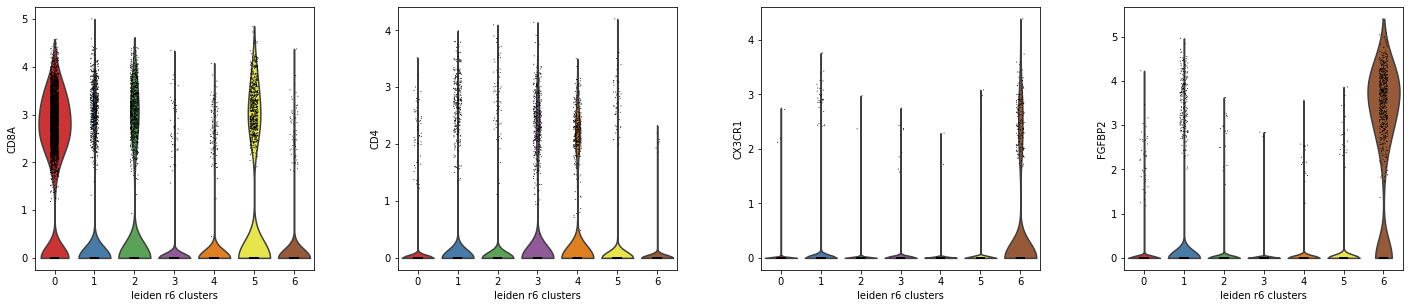

In [75]:
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_lung_Tcell, ['CD8A', 'CD4','CX3CR1','FGFBP2'], groupby='leiden_r6_clusters')

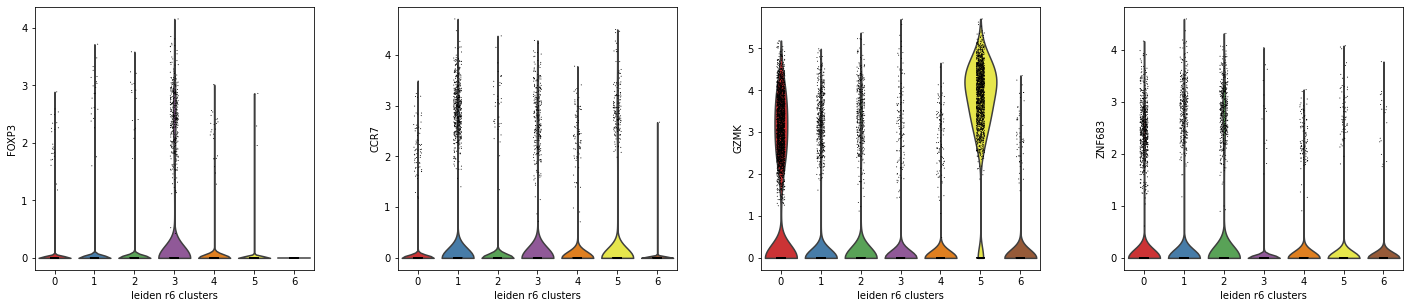

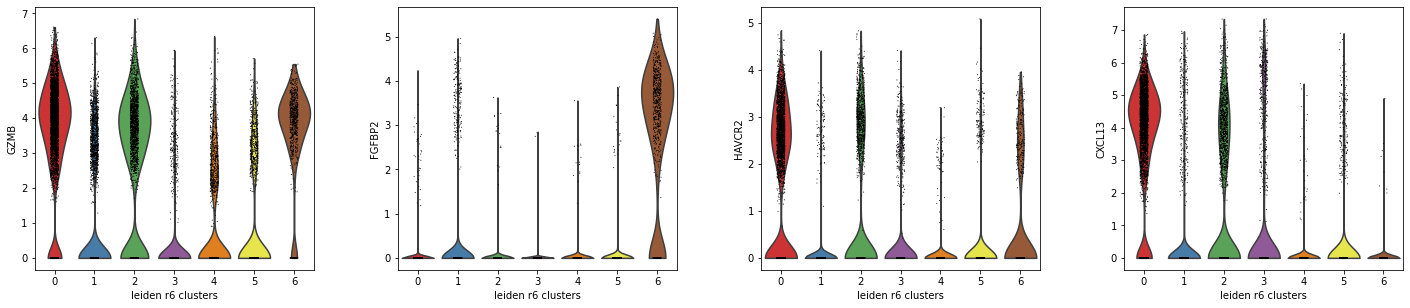

In [76]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_lung_Tcell, ['FOXP3','CCR7','GZMK','ZNF683'], groupby='leiden_r6_clusters' )
sc.pl.violin(adata_lung_Tcell, ['GZMB','FGFBP2','HAVCR2','CXCL13'], groupby='leiden_r6_clusters' )

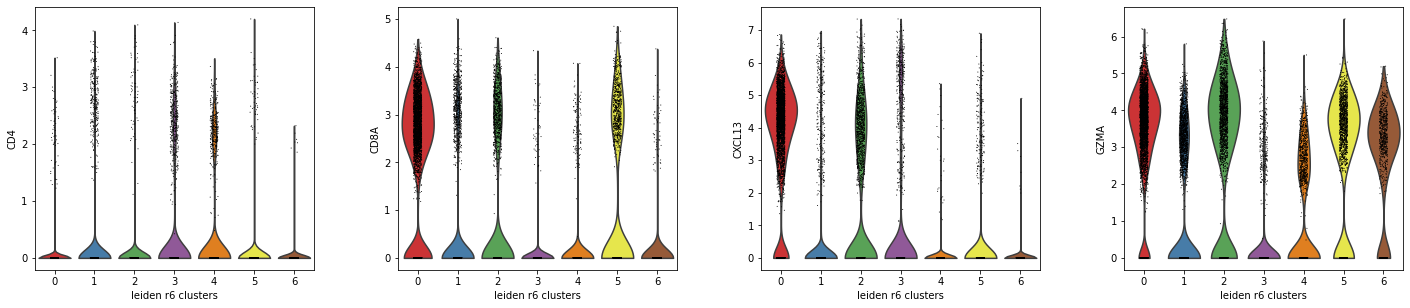

In [77]:
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata_lung_Tcell, ['CD4','CD8A','CXCL13','GZMA'], groupby='leiden_r6_clusters' )

### Remove NK cluster

In [79]:
new_cluster_names = ['C0_CD8_HAVCR2','C1_CD4_CCR7','C2_CD8_ZNF683','C3_CD4_FOXP3','C4_CD4_GZMKA','C5_CD8_GZMK','C6_NK_FGFBP2']
adata_lung_Tcell.rename_categories('leiden_r6_clusters', new_cluster_names)

In [80]:
adata_lung_Tcell = adata_lung_Tcell[adata_lung_Tcell.obs['leiden_r6_clusters'].isin(['C0_CD8_HAVCR2','C1_CD4_CCR7','C2_CD8_ZNF683','C3_CD4_FOXP3','C4_CD4_GZMKA','C5_CD8_GZMK']),:]

### Marker genes

In [82]:
sc.tl.rank_genes_groups(adata_lung_Tcell, 'leiden_r6_clusters', method='wilcoxon')
pd.DataFrame(adata_lung_Tcell.uns['rank_genes_groups']['names']).head(20)

ranking genes


Trying to set attribute `.uns` of view, copying.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


C0_CD8_HAVCR2 C1_CD4_CCR7 C2_CD8_ZNF683 C3_CD4_FOXP3 C4_CD4_GZMKA  \
0         CXCL13        IL7R        TMSB4X          LTB         FTH1   
1           NKG7        BTG1           CD7      TNFRSF4       EEF1A1   
2           LAG3       CXCR4        HSPA1A         SAT1        ANXA1   
3           GZMB       TXNIP          CCL5         IL32        SFTPC   
4          ISG15         FOS        HSPA1B     TNFRSF18          VIM   
5           CD8A        JUNB           ID2        TIGIT        ZFP36   
6           IFI6     TSC22D3          GZMA         BATF        CRIP1   
7          GAPDH        CD69         KLRD1       ARID5B          FTL   
8           LY6E     ZFP36L2          CD63         SELL         TPT1   
9           GZMA        TPT1          GZMB        RTKN2      S100A10   
10          CCL3        KLF6         KLRB1        IL2RA        SARAF   
11        HAVCR2       ANXA1      SH3BGRL3        CTLA4        APOC1   
12           MX1       SARAF          CTSW         UGP2         SRGN   
13          CCL4      PABPC1          PRF1          B2M         LMNA   
14          GZMH       DUSP1          CTSD         CD27       TAGLN2   
15          GNLY        CD52         SERF2        HLA-A         CREM   
16          CCL5      NFKBIA         DDIT4       TBC1D4       S100A4   
17          IFNG        BTG2          CD3D         PIM2         C1QA   
18          CTSW         FAU          PFN1        BIRC3         C1QB   
19        CCL4L2         B2M           JUN         ICA1       S100A6   

   C5_CD8_GZMK  
0         GZMK  
1         CST7  
2        CXCR4  
3       GIMAP7  
4        HLA-A  
5         CCL4  
6         CD8B  
7         GZMA  
8       CLDND1  
9         CMC1  
10      GIMAP4  
11       HLA-B  
12       HLA-E  
13        LYAR  
14       TXNIP  
15        BTG1  
16        CCL5  
17       KLRG1  
18         B2M  
19        NKG7

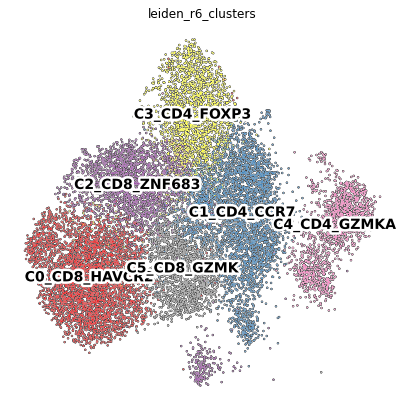

In [83]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_lung_Tcell, color='leiden_r6_clusters', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=5,frameon=False,
           title='leiden_r6_clusters', palette='Set1')

In [84]:
marker_genes_dict = {'T-cell': ['CD8A','CD4'],
                     'C0_CD8_HAVCR2': ['HAVCR2'],
                     'C1_CD4_CCR7': ['CCR7'],
                     'C2_CD8_ZNF683': ['ZNF683'],
                     'C3_CD4_FOXP3': ['FOXP3'],
                     'C4_CD4_GZMA': ['GZMA'],
                     'C5_CD8_GZMK': ['GZMK'],
                     'C6_NK_FGFBP2' : ['FGFBP2','NKG7']}

### Marker genes x cluster

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden_r6_clusters']"]`
categories: C0_CD8_HAVCR2, C1_CD4_CCR7, C2_CD8_ZNF683, etc.
var_group_labels: T-cell, C0_CD8_HAVCR2, C1_CD4_CCR7, etc.


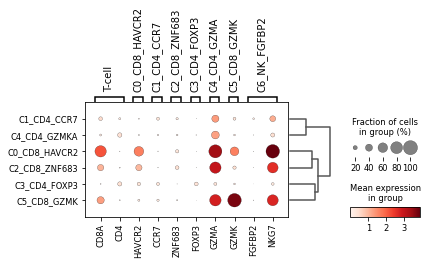

In [85]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata_lung_Tcell, marker_genes_dict, 'leiden_r6_clusters', dendrogram=True)

### Cluster correlation

In [86]:
sc.tl.dendrogram(adata_lung_Tcell, 'leiden_r6_clusters')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['leiden_r6_clusters']"]`


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_r6_clusters']`


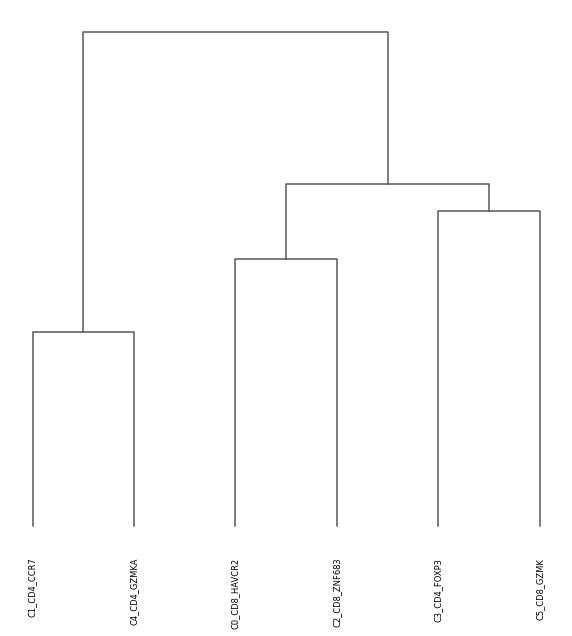

In [87]:
ax = sc.pl.dendrogram(adata_lung_Tcell, 'leiden_r6_clusters')

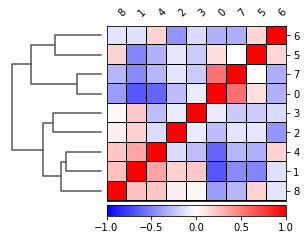

In [91]:
ax = sc.pl.correlation_matrix(adata_lung_Tcell, 'leiden_r8_clusters', figsize=(5,3.5))

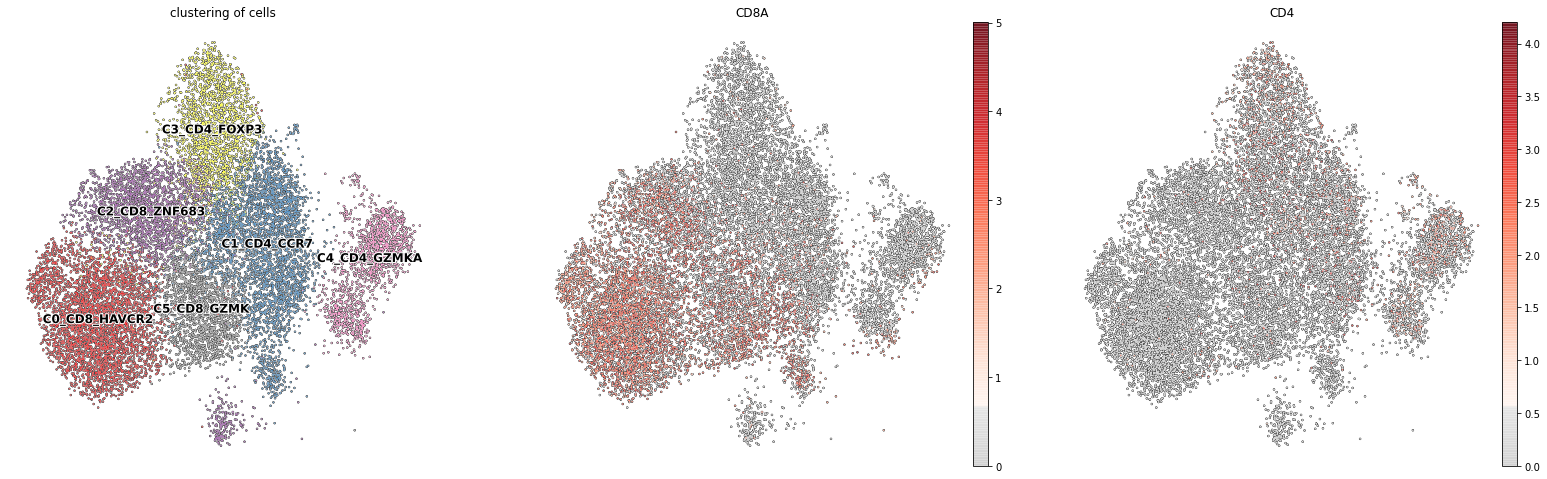

In [88]:
rcParams['figure.figsize'] = 8, 8
sc.pl.umap(adata_lung_Tcell, color=['leiden_r6_clusters','CD8A','CD4'],color_map=mymap, add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1')

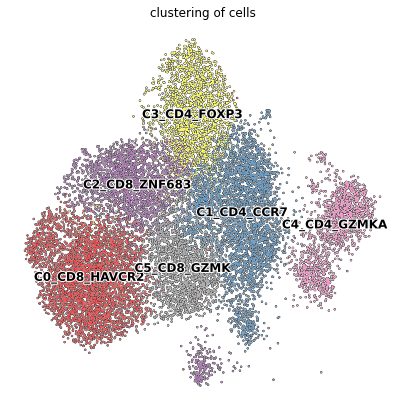

In [89]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata_lung_Tcell, color=['leiden_r6_clusters'], add_outline=True,legend_loc='on data', 
           legend_fontsize=12, legend_fontoutline=2,frameon=False,
           title='clustering of cells', palette='Set1',color_map=mymap)

### Cluster information

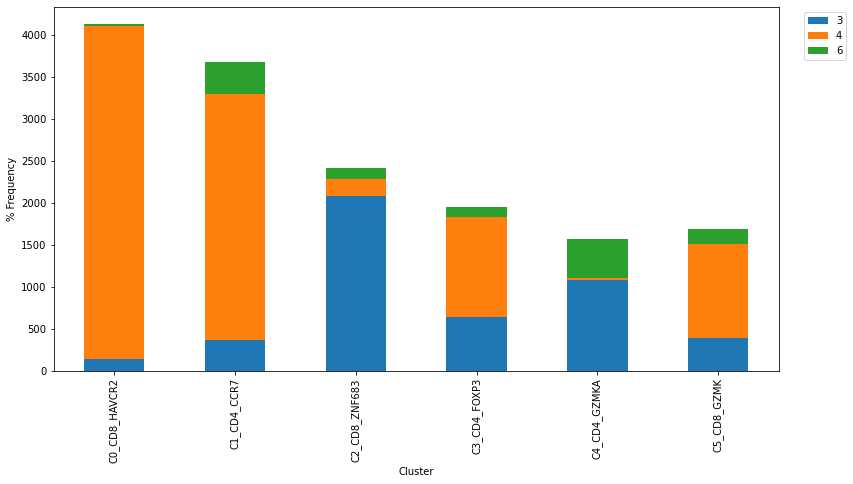

In [90]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata_lung_Tcell.obs.groupby("leiden_r6_clusters")["PatientNumber"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

### Export list and object

In [91]:
result = adata_lung_Tcell.uns['rank_genes_groups']

In [92]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Lung_output/Lung_DEGS.csv",header=True,index=False)

In [93]:
adata_lung_Tcell.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Lung_output/adata_lung_Tcell.h5ad")

... storing 'gene_biotype' as categorical
